# CMPE 597 Sp. Tp. Deep Learning - Term Project 

# *DINO Architecture - CIFAR10 Dataset*

## *Anıl Turgut* - *2022702072*
## *Selahattin Seha Cirit* - *2023705006*

In this Jupyter Notebook, a study was carried out by finetuning the classification model with the image embeddings obtained using the pre-trained self-supervised learning model that we proposed in the project. Image embeddings in this notebook were created using the **DINOv2vits14** model developed by MetaResearch. As the output of this model, there is an embedding list output with 384 dimensions for each image. The results of these embeddings resulting from the pretext task were analyzed using *Single Layer MLP* and *SupportVectorClassifier (SVC)* models.

Moreover, this notebook includes the analysis of *self-supervised learning* (spesifically DINO) with **CIFAR10** dataset. In the following tasks, we are introduce our work in detail. Let's move on.

## Task 1: Importing Libraries

In [1]:
# Importing necessary libraries
import copy
import cv2
import glob
import json
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as T
import torchvision.datasets as datasets
import tqdm
from tqdm.notebook import tqdm as tqdm_note
import zipfile
from copy import deepcopy
from PIL import Image
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import socket
from tensorflow.keras import datasets as tfdatasets, layers, models

The libraries to be used have been imported as in the cell above. *TensorFlow Keras*, *Torch* and *ScikitLearn* libraries were used when establishing classification models. Other libraries are also used for different purposes.

## Task 2.1: Extracting CIFAR10 Dataset

In [2]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
              'dog', 'frog', 'horse', 'ship', 'truck']
(train_images, train_labels), (test_images, test_labels) = tfdatasets.cifar10.load_data()

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.

Reference: https://www.cs.toronto.edu/~kriz/cifar.html

*class_names* list is defined accordingly to the referenced source to test the results properly.

## Task 2.2: Pretext Task - Preparing DINO model

In [4]:
torch.manual_seed(88)
dinov2_vits14 = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14")

Using cache found in C:\Users\anil.turgut/.cache\torch\hub\facebookresearch_dinov2_main
C:\Users\anil.turgut/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
C:\Users\anil.turgut/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
C:\Users\anil.turgut/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


DINO, a new self supervised system by Facebook AI, is able to learn incredible representations from unlabeled data.It was introduced in their paper “Emerging Properties in Self-Supervised Vision Transformers”. This architecture mainly uses the vision transformers (ViT) to extract information/representation from unlabeled dataset. In other words, A Student ViT learns to predict global features in an image from local patches supervised by the cross entropy loss from a momentum Teacher ViT’s embeddings while doing centering and sharpening to prevent mode collapse.

DINO is currently the state of art architecture in Self-Supervised Image Classification - ImageNet1K. That's why we have used this architecture as the backbone of our project. There 4 kind of pretrained backbone models of this architecture provided by *facebookresearch* and we have used the **ViT-S/14 distilled** model with almost **21M** parameters. 

Using **Torch.hub**, we have loaded the model to our working environment to compute image embeddings as pretext task.

References:
- https://github.com/facebookresearch/dinov2
- https://arxiv.org/abs/2104.14294
- https://towardsdatascience.com/dino-emerging-properties-in-self-supervised-vision-transformers-summary-ab91df82cc3c

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu") # sometimes not enough gpu memory
#device = "cpu"
device

device(type='cuda')

Device is mainly selected as Cuda due to its performance. However, our local machines have not powerful gpu (*NVIDIA GeForce MX330 2GB*), sometimes *CPU* is selected intentionally.

In [6]:
dinov2_vits14.to(device)

DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (n

We moved our DINO model to the device to ensure that all computations involving the model parameters and inputs will be performed on the specified device. Also, all the computed images' embeddings will have **384** dimensions with this DINO model.

In [7]:
transform_image = T.Compose([T.ToTensor(), T.Resize(244), T.CenterCrop(224), T.Normalize([0.5], [0.5])])

def load_image(img: str) -> torch.Tensor:
    """
    Load an image and return a tensor that can be used as an input to DINOv2.
    """
    img = Image.open(img)

    transformed_img = transform_image(img)[:3].unsqueeze(0)

    return transformed_img

def plot_image(tensor_image):
    # Convert tensor to NumPy array and transpose dimensions
    numpy_img = tensor_image.squeeze().permute(1, 2, 0).cpu().numpy()

    # Plot the image
    plt.imshow(numpy_img)
    plt.axis('off')
    plt.show()
    

def compute_embeddings(images: list) -> list:
    """
    Create an index that contains all of the images in the specified list of files.
    """
    all_embeddings = []
    
    with torch.no_grad():
        
      for image in tqdm_note(images):
        
        image = transform_image(image)[:3].unsqueeze(0)
        embeddings = dinov2_vits14(image.to(device))
        all_embeddings.append(np.array(embeddings[0].cpu().numpy()).reshape(1, -1).tolist())



    return all_embeddings


Cell above have 3 functions to help while transforming image to the shape that dino can understand. *load_image* and *plot_image* functions basically loads the *.jpg* or *.png* format images, transformes to the tensor and plot the loaded image respectively. 

*compute_embeddings* function is defined to compute image embeddings from the given image list using DINO model. In our project, CIFAR training and test image datasets will be executed by this model and output embeddings will be an input for our downstream task *-Classification-*. 

## 2.3 Computing/Loading Embeddings

Using *compute_embeddings* function above, we will compute the each image embeddings in train/test dataset. Then, we are going to store this embeddings as JSON file not to recalculate again and again. 

In [ ]:
embeddings = compute_embeddings(train_images)

with open("CIFAR10Embeddings/_dinocifar10_all_embeddings.json", "w") as f:
        f.write(json.dumps(embeddings))

test_embeddings = compute_embeddings(test_images)

with open("CIFAR10Embeddings/_dinocifar10_all_embeddings_test.json", "w") as f:
        f.write(json.dumps(test_embeddings))

In [8]:
with open('CIFAR10Embeddings/_dinocifar10_all_embeddings.json') as f:
    embeddings = json.load(f)
    
    
with open('CIFAR10Embeddings/_dinocifar10_all_embeddings_test.json') as f:
    test_embeddings = json.load(f)

**embeddings** are the computed embeddings for the CIFAR10 training images (50000 records) and **test_embeddings** are the computed embeddings for the CIFAR10 training images (10000 records). We do not need to compute the embeddings for label (y values) since the pretext task is unlabeled. 

In [9]:
copied_training_embeddings = embeddings.copy()
copied_training_embeddings = np.array(copied_training_embeddings).reshape(-1, 384)
copied_test_embeddings = test_embeddings.copy()
copied_test_embeddings = np.array(copied_test_embeddings).reshape(-1, 384)

Copied embeddings will be used in the SVC model in below.

## 2.4 Preparing Dataset for Training

In [10]:
X_train = embeddings
X_train = np.array(X_train).reshape(-1, 384)
y_train = train_labels
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit(y_train)
y_train = ohe.transform(y_train)
X_test = test_embeddings
X_test = np.array(X_test).reshape(-1, 384)
y_test = test_labels
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit(y_test)
y_test = ohe.transform(y_test)

In [11]:
# convert pandas DataFrame (X) and numpy array (y) into PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [13]:
print("Shape of X_train:",X_train.shape)
print("Shape of y_train:",y_train.shape)
print("Shape of X_test:",X_test.shape)
print("Shape of y_test:",y_test.shape)

Shape of X_train: torch.Size([50000, 384])
Shape of y_train: torch.Size([50000, 10])
Shape of X_test: torch.Size([10000, 384])
Shape of y_test: torch.Size([10000, 10])


In preparing dataset section, we reshaped the computed embeddings of images as (-1,384). Also labels are redefined as one-hot-encoded list. Thus, each label record consists of 10 dimensions and including one *1* rest is *0*.

All the dataset items are converted to *tensor* to be used in perceptron model.

## 3.1 Downstream Task - Single Layer Classification Perceptron Model

In [14]:
class DinoVisionTransformerClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(384, 256)
        self.act = nn.ReLU()
        self.output = nn.Linear(256, 10)

    def forward(self, x):
        x = self.act(self.hidden(x))
        x = self.output(x)
        return x
    
# loss metric and optimizer
model = DinoVisionTransformerClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# prepare model and training parameters
n_epochs = 25
batch_size = 64
batches_per_epoch = len(X_train) // batch_size

Classifier is designed to classify image labels using embeddings using Single Hidden Layer perceptron model. 384 image embeddings for each image will be corresponded by the hidden layer and 256 hidden units in that layer. Output will be 10 class values through FC layer.

Loss is selected as CrossEntropyLoss since the problem is multi-class classification and optimizer is selected as *Adam* optimizer to reduce the effects of hyperparameters and including momentum and SGD mechanism.

After analyzing the model training process, epoch numbers and batch sizes selected accordingly.

In [15]:
best_acc = - np.inf   # init to negative infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []

In [16]:
# training loop
for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    # set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # take a batch
            start = i * batch_size
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(
                loss=float(loss),
                acc=float(acc)
            )
    # set model in evaluation mode and run through the test set
    model.eval()
    y_pred = model(X_test)
    ce = loss_fn(y_pred, y_test)
    acc = (torch.argmax(y_pred, 1) == torch.argmax(y_test, 1)).float().mean()
    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)
    if acc > best_acc:
        best_acc = acc
        best_weights = copy.deepcopy(model.state_dict())
    print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc*100:.1f}%")

# Restore best model
model.load_state_dict(best_weights)

Epoch 0: 100%|████████████████████████████████████████████| 781/781 [00:04<00:00, 167.31batch/s, acc=0.938, loss=0.173]


Epoch 0 validation: Cross-entropy=0.16, Accuracy=94.6%


Epoch 1: 100%|████████████████████████████████████████████| 781/781 [00:04<00:00, 160.20batch/s, acc=0.938, loss=0.111]


Epoch 1 validation: Cross-entropy=0.16, Accuracy=94.7%


Epoch 2: 100%|███████████████████████████████████████████| 781/781 [00:04<00:00, 167.85batch/s, acc=0.984, loss=0.0491]


Epoch 2 validation: Cross-entropy=0.16, Accuracy=95.1%


Epoch 3: 100%|███████████████████████████████████████████| 781/781 [00:04<00:00, 170.57batch/s, acc=0.984, loss=0.0363]


Epoch 3 validation: Cross-entropy=0.18, Accuracy=94.9%


Epoch 4: 100%|███████████████████████████████████████████| 781/781 [00:04<00:00, 161.08batch/s, acc=0.984, loss=0.0312]


Epoch 4 validation: Cross-entropy=0.20, Accuracy=95.2%


Epoch 5: 100%|███████████████████████████████████████████| 781/781 [00:04<00:00, 171.57batch/s, acc=0.984, loss=0.0281]


Epoch 5 validation: Cross-entropy=0.21, Accuracy=95.0%


Epoch 6: 100%|███████████████████████████████████████████| 781/781 [00:04<00:00, 162.23batch/s, acc=0.984, loss=0.0327]


Epoch 6 validation: Cross-entropy=0.24, Accuracy=94.9%


Epoch 7: 100%|███████████████████████████████████████████| 781/781 [00:04<00:00, 175.74batch/s, acc=0.984, loss=0.0328]


Epoch 7 validation: Cross-entropy=0.26, Accuracy=95.0%


Epoch 8: 100%|██████████████████████████████████████████████| 781/781 [00:04<00:00, 175.54batch/s, acc=1, loss=0.00554]


Epoch 8 validation: Cross-entropy=0.28, Accuracy=94.5%


Epoch 9: 100%|███████████████████████████████████████████████| 781/781 [00:04<00:00, 182.89batch/s, acc=1, loss=0.0104]


Epoch 9 validation: Cross-entropy=0.27, Accuracy=95.0%


Epoch 10: 100%|█████████████████████████████████████████████| 781/781 [00:04<00:00, 177.93batch/s, acc=1, loss=0.00793]


Epoch 10 validation: Cross-entropy=0.30, Accuracy=94.8%


Epoch 11: 100%|█████████████████████████████████████████████| 781/781 [00:04<00:00, 173.58batch/s, acc=1, loss=0.00991]


Epoch 11 validation: Cross-entropy=0.31, Accuracy=94.9%


Epoch 12: 100%|█████████████████████████████████████████████| 781/781 [00:04<00:00, 183.58batch/s, acc=1, loss=0.00142]


Epoch 12 validation: Cross-entropy=0.33, Accuracy=94.7%


Epoch 13: 100%|██████████████████████████████████████████| 781/781 [00:04<00:00, 183.82batch/s, acc=0.984, loss=0.0198]


Epoch 13 validation: Cross-entropy=0.35, Accuracy=94.5%


Epoch 14: 100%|█████████████████████████████████████████████| 781/781 [00:04<00:00, 177.75batch/s, acc=1, loss=0.00306]


Epoch 14 validation: Cross-entropy=0.41, Accuracy=94.4%


Epoch 15: 100%|████████████████████████████████████████████| 781/781 [00:04<00:00, 157.11batch/s, acc=1, loss=0.000185]


Epoch 15 validation: Cross-entropy=0.37, Accuracy=95.0%


Epoch 16: 100%|█████████████████████████████████████████████| 781/781 [00:04<00:00, 161.55batch/s, acc=1, loss=0.00328]


Epoch 16 validation: Cross-entropy=0.40, Accuracy=94.8%


Epoch 17: 100%|████████████████████████████████████████████| 781/781 [00:04<00:00, 174.12batch/s, acc=1, loss=0.000272]


Epoch 17 validation: Cross-entropy=0.37, Accuracy=95.1%


Epoch 18: 100%|██████████████████████████████████████████| 781/781 [00:04<00:00, 176.98batch/s, acc=0.984, loss=0.0131]


Epoch 18 validation: Cross-entropy=0.39, Accuracy=94.8%


Epoch 19: 100%|████████████████████████████████████████████| 781/781 [00:04<00:00, 176.64batch/s, acc=1, loss=0.000573]


Epoch 19 validation: Cross-entropy=0.37, Accuracy=95.2%


Epoch 20: 100%|█████████████████████████████████████████████| 781/781 [00:04<00:00, 175.81batch/s, acc=1, loss=0.00497]


Epoch 20 validation: Cross-entropy=0.44, Accuracy=94.8%


Epoch 21: 100%|█████████████████████████████████████████████| 781/781 [00:05<00:00, 151.00batch/s, acc=1, loss=0.00114]


Epoch 21 validation: Cross-entropy=0.41, Accuracy=95.3%


Epoch 22: 100%|████████████████████████████████████████████| 781/781 [00:04<00:00, 172.18batch/s, acc=1, loss=0.000405]


Epoch 22 validation: Cross-entropy=0.45, Accuracy=94.9%


Epoch 23: 100%|█████████████████████████████████████████████| 781/781 [00:04<00:00, 174.57batch/s, acc=1, loss=0.00151]


Epoch 23 validation: Cross-entropy=0.44, Accuracy=95.2%


Epoch 24: 100%|███████████████████████████████████████████| 781/781 [00:04<00:00, 168.79batch/s, acc=0.984, loss=0.019]


Epoch 24 validation: Cross-entropy=0.47, Accuracy=95.1%


<All keys matched successfully>

Model is trained 25 epochs and resulted with almost 97% percent training accuracy and 95& test accuracy which shows that the embeddings are successively learned without overfitting. 

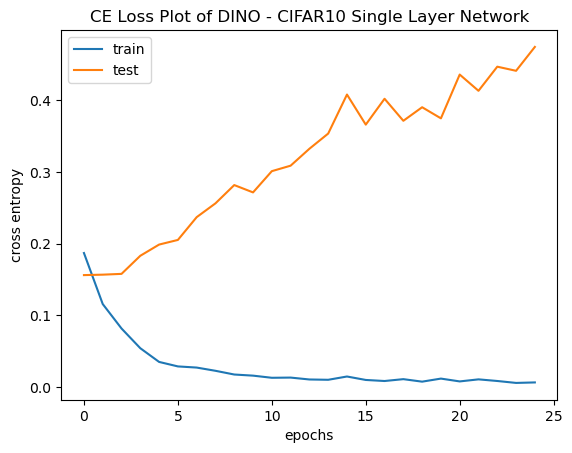

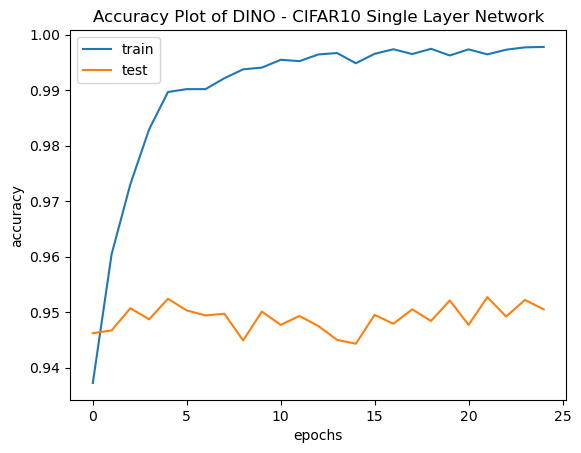

In [17]:
# Plot the loss and accuracy
plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.title("CE Loss Plot of DINO - CIFAR10 Single Layer Network")
plt.legend()
plt.show()

plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("Accuracy Plot of DINO - CIFAR10 Single Layer Network")
plt.legend()
plt.show()

Accuracy in training is continuosly improving as expected, whereas test accuracy kind of oscillates but improved. Double depth phenomenon can be seen in second plot. But CE Loss graph shows us that improving training performance might result with decrease in test performance as well. 

## 3.2 Downstream Task - TensorFlow Trainer Classification

In this part, we have used the *TensorFlow Trainer* module to train classification network. Architecture is similar to the previous model.

In [19]:
from tensorflow.keras import models, layers

tf_model = models.Sequential()

tf_model.add(layers.Dense(256, activation='relu', input_shape=(384,)))

tf_model.add(layers.Dense(10, activation='softmax')) 

tf_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                      │ (None, 256)                 │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 101,130 (395.04 KB)

 Trainable params: 101,130 (395.04 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
tf_model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Optimizer and loss function is selected as *adam* and *SparseCategoricalCrossEntropy* to see whether there is any improvement in changing loss function.

In [21]:
history = tf_model.fit(copied_training_embeddings, train_labels, epochs=25,
                      validation_data = (copied_test_embeddings, test_labels))

Epoch 1/25


C:\Users\anil.turgut\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\nn.py:599: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8998 - loss: 0.3441 - val_accuracy: 0.9480 - val_loss: 0.1598
Epoch 2/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9617 - loss: 0.1088 - val_accuracy: 0.9492 - val_loss: 0.1547
Epoch 3/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9739 - loss: 0.0742 - val_accuracy: 0.9492 - val_loss: 0.1590
Epoch 4/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9812 - loss: 0.0547 - val_accuracy: 0.9486 - val_loss: 0.1817
Epoch 5/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9867 - loss: 0.0390 - val_accuracy: 0.9499 - val_loss: 0.1945
Epoch 6/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9892 - loss: 0.0292 - val_accuracy: 0.9499 - val_loss: 0.2158
Epoch 7/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9918 - loss: 0.0228 - val_accuracy: 0.9492 - val_loss: 0.2468
Epoch 8/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9925 - loss: 0.0209 - val_accurac

In [24]:
y_train.shape

torch.Size([50000, 10])

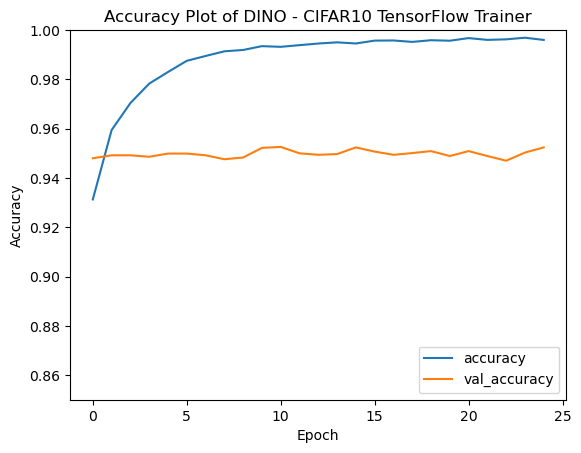

In [22]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Accuracy Plot of DINO - CIFAR10 TensorFlow Trainer")
plt.ylim([0.85, 1])
plt.legend(loc='lower right')

Accuracy plot shows that the results of *TF Trainer* and *Single Layer Perceptron* models are similar and satisfied. We can cover almost 95% of the validation image dataset.

Let's finally analyze the *Support Vector Classifier (SVC)* model to analyze the results.

## 3.3 Downstream Task - Classification Using Support Vector Classifier (SVC)

*SVC with gamma parameter* is created as the downstream classification model

In [27]:
from sklearn import svm

clf = svm.SVC(gamma='scale')

print(len(embeddings))

clf.fit(np.array(embeddings).reshape(-1, 384), train_labels)

50000


C:\Users\anil.turgut\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC()

Training is completed between training image embeddings and training labels (without one hot encoding)

In [29]:
# train metrics
y_pred_train_list = []

for embed in tqdm_note(embeddings):
    
    y_pred = clf.predict(np.array(embed).reshape(1, -1))
    y_pred_train_list.append(y_pred[0])


  0%|          | 0/50000 [00:00<?, ?it/s]

In [31]:
y_pred_test_list = []

for embed in tqdm_note(test_embeddings):
    
    y_pred = clf.predict(np.array(embed).reshape(1, -1))
    y_pred_test_list.append(y_pred[0])

  0%|          | 0/10000 [00:00<?, ?it/s]

In [143]:
with open("CIFAR10Predictions/dinocifar10trainingpreds.json", "w") as f:
        f.write(json.dumps(np.array(y_pred_train_list).tolist()))

with open("CIFAR10Predictions/dinocifar10testpreds.json", "w") as f:
        f.write(json.dumps(np.array(y_pred_test_list).tolist()))

In [23]:
with open('CIFAR10Predictions/dinocifar10trainingpreds.json') as f:
    y_pred_train_list = json.load(f)
    
    
with open('CIFAR10Predictions/dinocifar10testpreds.json') as f:
    y_pred_test_list = json.load(f)

In [24]:
# Calculate evaluation metrics on the training data
accuracy_train = accuracy_score(train_labels, y_pred_train_list)
precision_train = precision_score(train_labels, y_pred_train_list, average='weighted')
recall_train = recall_score(train_labels, y_pred_train_list, average='weighted')
f1_train = f1_score(train_labels, y_pred_train_list, average='weighted')

print("Training Accuracy:", round(accuracy_train,6))
print("Training Precision:", round(precision_train,6))
print("Training Recall:", round(recall_train,6))
print("Training F1-score:", round(f1_train,6))

Training Accuracy: 0.98256
Training Precision: 0.982671
Training Recall: 0.98256
Training F1-score: 0.982574


In [25]:
# Calculate evaluation metrics on test data
accuracy = accuracy_score(test_labels, y_pred_test_list)
precision = precision_score(test_labels, y_pred_test_list, average='weighted')
recall = recall_score(test_labels, y_pred_test_list, average='weighted')
f1 = f1_score(test_labels, y_pred_test_list, average='weighted')

print("Test Accuracy:", round(accuracy,4))
print("Test Precision:", round(precision,4))
print("Test Recall:", round(recall,4))
print("Test F1-score:", round(f1,4))


Test Accuracy: 0.9583
Test Precision: 0.9587
Test Recall: 0.9583
Test F1-score: 0.9584


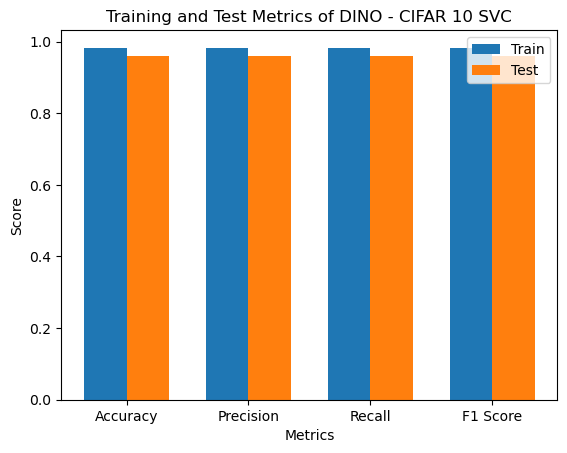

In [26]:
train_metrics = [accuracy_train, precision_train, recall_train, f1_train]
test_metrics = [accuracy, precision, recall, f1]
metrics_labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
num_metrics = len(metrics_labels)

index = np.arange(num_metrics)

bar_width = 0.35

fig, ax = plt.subplots()

train_bars = ax.bar(index, train_metrics, bar_width, label='Train')

test_bars = ax.bar(index + bar_width, test_metrics, bar_width, label='Test')

ax.set_xlabel('Metrics')
ax.set_ylabel('Score')
ax.set_title('Training and Test Metrics of DINO - CIFAR 10 SVC')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(metrics_labels)
ax.legend()

plt.show()


*SVC* performed also very well using image embeddings, it has both train and test accuracy similar to the neural networks we have created (over 95%). But training and making predictions with that model is slower than previous ones.

## 4.1 Testing Classifier Model Performance on Image from different Dataset

In this part, we will be testing our three downstream models with different dataset(different than CIFAR)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


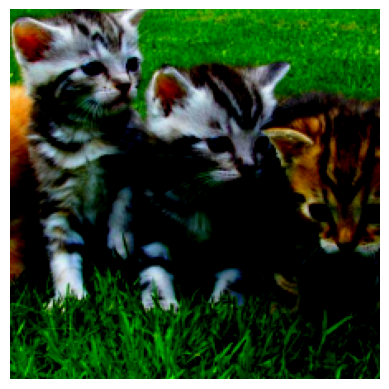

In [111]:
#input_file = "C:\\Users\\anil.turgut\\Desktop\\CMPE597\\Notebooks\\cat\\730d6a8791.jpg"
input_file = "C:\\Users\\anil.turgut\\Desktop\\CMPE597\\Project\\Code\\ExampleTestImages\\81b58d7d07_jpg.rf.005790e48c1eec2b2f9b3a3cc6f58cb4.jpg"
new_image = load_image(input_file)

plot_image(new_image)

Image is uploaded using *load_image* function

In [107]:
#device = "cpu"
dinov2_vits14.to(device)

DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (n

### 4.1.1 -  SVC

In [108]:
with torch.no_grad():
    embedding = dinov2_vits14(new_image.to(device))

    prediction = clf.predict(np.array(embedding[0].cpu()).reshape(1, -1))

    print("Predicted class: " + class_names[prediction[0]])

Predicted class: cat


### 4.1.2 -  Single Layer Torch Network

In [109]:
with torch.no_grad():
    
    model.eval()
    prediction = model(embedding)
    max_value, index = torch.max(prediction, dim = 1)
    
    print("Predicted class: " + class_names[index])

Predicted class: cat


### 4.1.3 -  TF Trainer

In [110]:
prediction = tf_model.predict(embedding)

class_names[np.argmax(a,axis = 1)[0]]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


'cat'

All of 3 classifiers can can correctly classify images which are not from neither test nor training dataset

## 5. Results/Analysis

*DINO* is a self-supervised learning (SSL) model architecture which is developed by *FacebookAI* is the state of art architecture in SSL-Image Classification context. In this notebook, we have analyzed ImageNet1k fed pretrained *dino* model with the *CIFAR10* dataset. Image embeddings obtained from *DINO* model are used as an input to train 3 different classification model/networks as following: *Single Layer Network*, *TensorFlow Trainer* and *Support Vector Classifier*.

All of the 3 models performed significantly well in both *CIFAR* training and test dataset almost over **95%** accuracy. In other words, without memorizing, output embeddings are perfectly fit to these models to classify unknown images' labels. 

In terms of performance/memory of the algorithm analysis, *neural network classifiers* are more efficient than the *SVC* in terms of both speed and the memory usage.

## References

- https://www.cs.toronto.edu/~kriz/cifar.html
- https://github.com/facebookresearch/dinov2
- https://arxiv.org/abs/2104.14294
- https://towardsdatascience.com/dino-emerging-properties-in-self-supervised-vision-transformers-summary-ab91df82cc3c
- https://arxiv.org/abs/2010.11929v2
- https://arxiv.org/abs/1706.03762
- https://paperswithcode.com/sota/self-supervised-image-classification-on